In [1]:
import pandas as pd 
import numpy as np 
import rasterio
from matplotlib import pyplot as plt
# Just run this block. Please do not modify the following code.
import math
import time
import io
import numpy as np
import csv
from IPython.display import Image, display

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Pytorch package
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

Visualize a TIF

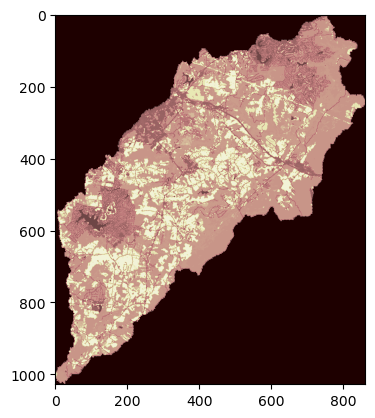

In [2]:
img = rasterio.open('../Data/03539600_Tif/NLCD.tif')
full_img = img.read(1)
plt.imshow(full_img, cmap='pink')

In [3]:
num_bands = img.count
num_bands

1

In [4]:
img.crs

CRS.from_epsg(6575)

In [5]:
# check the sizes of the images, their channels, and channel data types
file_list = ['ACC.tif', 'ASPECT.tif', 'DEM.tif','DIR.tif','HYDRO.tif','MFC.tif','NLCD.tif','PRISM.tif','ROUGH.tif','SLOPE.tif','TRI.tif']
for file in file_list:
    with rasterio.open(f'../Data/03539600_Tif/{file}') as img:
        shape = str(img.shape)
        channels = str(img.count)
        types = str(img.dtypes)
        print(f"{file.ljust(15)}: {shape.ljust(15)} : {channels} : {types}")

ACC.tif        : (368, 309)      : 1 : ('uint32',)
ASPECT.tif     : (368, 309)      : 1 : ('float32',)
DEM.tif        : (368, 309)      : 1 : ('int16',)
DIR.tif        : (368, 309)      : 1 : ('uint8',)
HYDRO.tif      : (3084, 2589)    : 1 : ('float32',)
MFC.tif        : (3084, 2589)    : 1 : ('float32',)
NLCD.tif       : (1028, 863)     : 1 : ('uint8',)
PRISM.tif      : (7, 6)          : 1 : ('float32',)
ROUGH.tif      : (368, 309)      : 1 : ('float32',)
SLOPE.tif      : (397, 333)      : 1 : ('float32',)
TRI.tif        : (368, 309)      : 1 : ('float32',)


Stack Mulitple TIF bands into one output image for a HydroShed

In [6]:
# Read metadata of first file
with rasterio.open("../Data/03539600_Tif/ACC.tif") as src0:
    meta = src0.meta
    meta["dtype"] = "float32"

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rasterio.open('stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rasterio.open("../Data/03539600_Tif/" + layer) as src1:
            dst.write_band(id, src1.read(1))

In [41]:
print(dst.count)
print(dst.shape)
print(dst.dtypes)

11
(368, 309)
('float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32', 'float32')


Fixed! Just force data type to float 32 when building the original geotiff concat. 

There may be a problem in the future though: I'm not sure how resampling works in the big geotiff since the individuals are different sizes (see above).

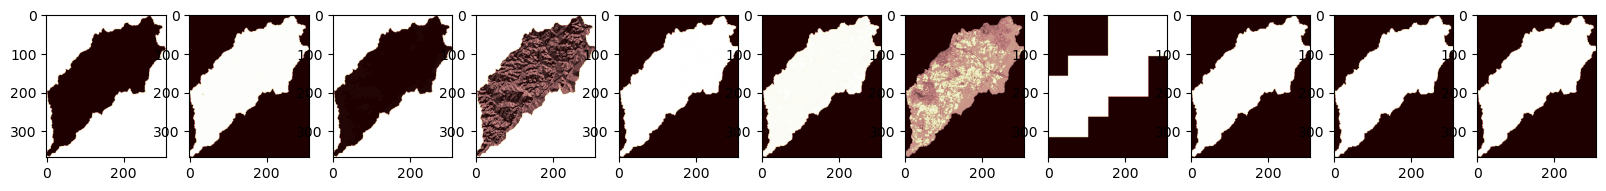

In [7]:
#TODO: make an outer loop over multiple regions to see which of these geotiffs we can just discard
#TODO: get sequential prism data to see if it actually changes

# sanity checks - see if the new image makes sense
with rasterio.open("./stack.tif") as image:
    fig, axes = plt.subplots(ncols=len(file_list))
    fig.set_size_inches(20, 10)

    for i, col in enumerate(axes):
        col.imshow(image.read(i+1), cmap='pink')

    plt.show()

In [12]:

# image=np.vstack(image).astype(np.float32) <--- concatenates 11 dims into 1!

with rasterio.open("./stack.tif") as f:
    image = f.read()
    image = ToTensor()(image)

# get dimensions in right spots
image = torch.permute(image, (2,0,1))

# unsqueeze first dimension to allow batching
image = image.unsqueeze(0)

print(type(image))

<class 'torch.Tensor'>


In [13]:
image.shape

torch.Size([1, 368, 309, 11])